In [29]:
#%%
import re
import os
# add the parent directory to the path
import sys
sys.path.append('../../')
from fears.utils import AutoRate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pickle
import pandas as pd
import calibration_08302023 as cal
from utils import *
import seaborn as sns

ab_folder_path = '../experiment_data/tk_tet_03122024/AB'
od_folder_path = '../experiment_data/tk_tet_03122024/OD'

exp_layout = {0:(0,['B','C','D']),
              10:(0,['E','F','G']),
              50:(1,['B','C','D']),
              100:(1,['E','F','G']),
              'control':(2,['B','C','D']),
              400:(2,['E','F','G'])}

# These functions help with sorting the file names in natural order
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


# pickle_file = '../calibration_code/calibration_02152024.pkl'
pickle_file = '../calibration_code/calibration_02152024.pkl'
res = pickle.load(open(pickle_file,'rb'))

def ab_to_cfu(ab):
    return 10**(res.slope*np.log10(ab) + res.intercept)

rfu30_to_dilution = cal.run()

def od_to_cfu(OD):
    slope = 0.94
    intercept = 5.75
    return 10**(np.log10(OD) * slope + intercept)

In [30]:
cell_count_mean_od = {}
cell_count_std_od = {}

cell_count_raw_od = {}

od_raw = {}
od_raw_std = {}

for exp_key in exp_layout.keys():

    # get the data for a specific excel sheet
    plate,data = get_timeseries(od_folder_path,plate_num=exp_layout[exp_key][0])

    time_list = []

    data_t = np.zeros((3,8))

    for i in range(len(data)):

        dt = plate[i].get_start_time()
        time_list.append(dt)

        # arrange data (replicates,timepoints)
        

        row_indx = 0 # replicate index
        for row in exp_layout[exp_key][1]:
            # col_indx = 0
            # for col in range(10):
                # if col != 2: # ignore column 2 because of experimental mistake
            key = row + str(i+2) # col+2 because we start the experiment at col 2
            data_t[row_indx,i] = data[i][key] - 0.05
            # col_indx += 1
            row_indx += 1

    # cell_count_data = rfu_to_dilution(data_t,background_subtracted=False)
    data_t[data_t <= 0] = 1
    cell_count = od_to_cfu(data_t)
    # cell_count_log = rfu_to_dilution.predict(rfu_t.reshape(-1,1))

    cell_count_mean_od[exp_key] = np.mean(cell_count,axis=0)
    cell_count_std_od[exp_key] = np.std(cell_count,axis=0)

    cell_count_raw_od[exp_key] = cell_count

    od_raw[exp_key] = data_t
    od_raw_std[exp_key] = np.std(data_t,axis=0)

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time_od = np.array(time)

In [31]:
cell_count_mean_ab = {}
cell_count_std_ab = {}

cell_count_raw_ab = {}

ab_raw = {}
ab_raw_std = {}

for exp_key in exp_layout.keys():

    # get the data for a specific excel sheet
    plate,data = get_timeseries(ab_folder_path,plate_num=exp_layout[exp_key][0])

    time_list = []

    data_t = np.zeros((3,7))

    for i in range(len(data)):

        dt = plate[i].get_start_time()
        time_list.append(dt)

        # arrange data (replicates,timepoints)
        

        row_indx = 0 # replicate index
        for row in exp_layout[exp_key][1]:
            # col_indx = 0
            # for col in range(10):
                # if col != 2: # ignore column 2 because of experimental mistake
            key = row + str(i+2) # col+2 because we start the experiment at col 2
            data_t[row_indx,i] = data[i][key] - 200
            # col_indx += 1
            row_indx += 1

    # cell_count_data = rfu_to_dilution(data_t,background_subtracted=False)
    # data_t[data_t <= 0] = 1
    # cell_count = rfu30_to_dilution(data_t,background_subtracted=True)
    cell_count = ab_to_cfu(data_t)
    # cell_count_log = rfu_to_dilution.predict(rfu_t.reshape(-1,1))

    cell_count_mean_ab[exp_key] = np.mean(cell_count,axis=0)
    cell_count_std_ab[exp_key] = np.std(cell_count,axis=0)

    cell_count_raw_ab[exp_key] = cell_count

    ab_raw[exp_key] = data_t
    ab_raw_std[exp_key] = np.std(data_t,axis=0)

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time_ab = np.array(time)

/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_14260/1624813733.py:48: RuntimeWarning: invalid value encountered in log10
  return 10**(res.slope*np.log10(ab) + res.intercept)


In [32]:
time_ab

array([  0.        ,  39.18333333,  83.08333333, 122.71666667,
       162.13333333, 208.2       , 267.18333333])

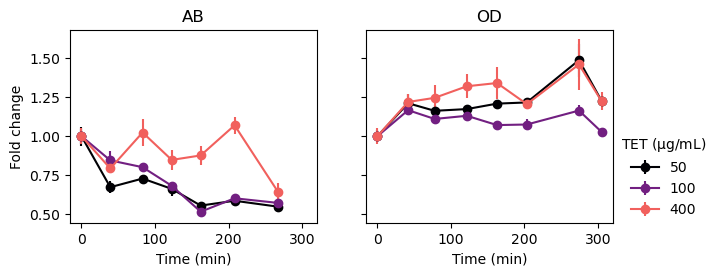

In [33]:
# fig,ax_list = plt.subplots(ncols=2,figsize=(7,2.5),sharey=True,sharex=True)

# cmap = sns.color_palette("magma", as_cmap=True)

# keys = [50,100,400]
# ax = ax_list[0]
# # for j,exp_key in enumerate(exp_layout.keys()):
# for j,exp_key in enumerate(keys):
#     if exp_key != 'control':
#         y = cell_count_mean_ab[exp_key]
#         err = cell_count_std_ab[exp_key]

#         # y = y/ctrl
#         err = err/y[0]
#         y = y/y[0]

#         ax.errorbar(time_ab,y,yerr=err,fmt='-o',color=cmap(j/3))

# # ax.set_yscale('log')

# ax = ax_list[1]
# for j,exp_key in enumerate(keys):
#     if exp_key != 'control':
#         y = cell_count_mean_od[exp_key]
#         err = cell_count_std_od[exp_key]

#         err = err/y[0]
#         y = y/y[0]

#         ax.errorbar(time_od,y,yerr=err,color=cmap(j/3),fmt='-o',label=exp_key)
    
# # ax.set_yscale('log')
        
# # for ax in ax_list:
# #     ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

# ax_list[0].set_xlabel('Time (min)')
# ax_list[1].set_xlabel('Time (min)')
# ax_list[0].set_ylabel('Fold change')

# # cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap),ax=ax,
#             # label='TET ($\mathrm{\mu g/mL}$)',orientation='horizontal',pad=0.2)
#             # boundari)

# # cbar.set_ticks([0,0.3,0.75])
# # cbar.set_ticklabels([50,100,400])

# ax_list[1].legend(frameon=False,ncol=1,title='TET ($\mathrm{\mu g/mL}$)',
#                   loc = [1.01,0])

# ax_list[0].set_title('AB')
# ax_list[1].set_title('OD')


# # fig.savefig('../../figures/ab_vs_od.pdf',bbox_inches='tight')
# fig.savefig('../../figures/tet_ab_vs_od.pdf',bbox_inches='tight',transparent=True)

Text(0.5, 1.0, 'OD')

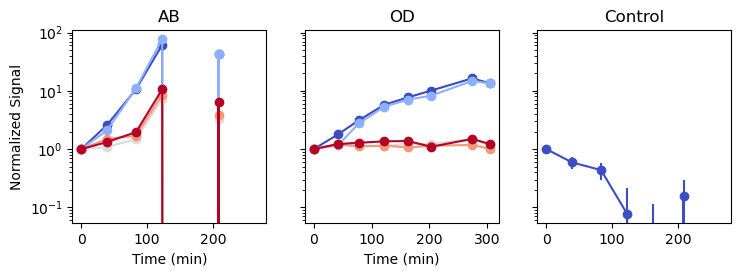

In [34]:
fig,ax_list = plt.subplots(ncols=3,figsize=(8.5,2.5),sharey=True)

cmap = sns.color_palette("coolwarm", as_cmap=True)

ax = ax_list[2]

key = 'control'
y = ab_raw[key][0]
err = ab_raw_std[key][0]

err = err/y[0]
ctrl = y/y[0]

ax.errorbar(time_ab,ctrl,yerr=err,fmt='-o',color=cmap(1))

ax.set_title('Control')

ax = ax_list[0]


for j,exp_key in enumerate(exp_layout.keys()):
    if exp_key != 'control':
        y = ab_raw[exp_key][0]
        err = ab_raw_std[exp_key][0]

        err = err/y[0]
        y = y/y[0]

        y = y/ctrl

        ax.errorbar(time_ab,y,yerr=err,fmt='-o',color=cmap(j/4))
    
ax.set_yscale('log')

ax = ax_list[1]

for j,exp_key in enumerate(exp_layout.keys()):
    if exp_key != 'control':
        y = od_raw[exp_key][0]
        err = od_raw_std[exp_key][0]

        err = err/y[0]
        y = y/y[0]

        ax.errorbar(time_od,y,yerr=err,fmt='-o',color=cmap(j/4))
    
ax.set_yscale('log')

ax_list[0].set_ylabel('Normalized Signal')

ax_list[0].set_xlabel('Time (min)')
ax_list[1].set_xlabel('Time (min)')

ax_list[0].set_title('AB')
ax_list[1].set_title('OD')



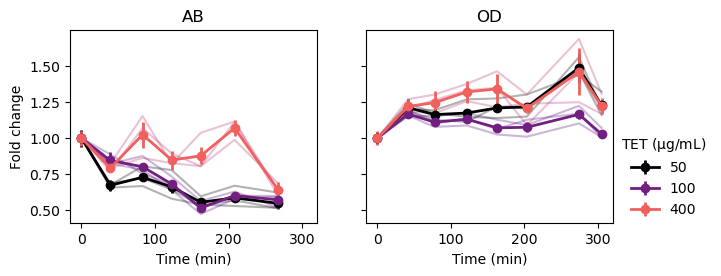

In [48]:
fig,ax_list = plt.subplots(ncols=2,figsize=(7,2.5),sharey=True,sharex=True)

cmap = sns.color_palette("magma", as_cmap=True)

keys = [50,100,400]
ax = ax_list[0]
# for j,exp_key in enumerate(exp_layout.keys()):
for j,exp_key in enumerate(keys):
    for i in range(3):
        y = cell_count_raw_ab[exp_key][i]
        # err = cell_count_std_ab[exp_key]

        # y = y/ctrl
        # err = err/y[0]
        y = y/y[0]
        ax.plot(time_ab,y,color=cmap(j/4),alpha=0.3)
        # ax.errorbar(time_ab,y,yerr=err,fmt='-o',color=cmap(j/4))

    y = cell_count_mean_ab[exp_key]
    err = cell_count_std_ab[exp_key]

    err = err/y[0]
    y = y/y[0]

    ax.errorbar(time_ab,y,yerr=err,fmt='-o',color=cmap(j/3),label=exp_key,linewidth=2)

# ax.set_yscale('log')

ax = ax_list[1]
for j,exp_key in enumerate(keys):
    
    for i in range(3):
        y = cell_count_raw_od[exp_key][i]
        # err = cell_count_std_od[exp_key]

        # err = err/y[0]
        y = y/y[0]
        ax.plot(time_od,y,color=cmap(j/4),alpha=0.3)
        # ax.errorbar(time_od,y,yerr=err,color=cmap(j/4),fmt='-o',label=exp_key)

    y = cell_count_mean_od[exp_key]
    err = cell_count_std_od[exp_key]

    err = err/y[0]
    y = y/y[0]
    
    ax.errorbar(time_od,y,yerr=err,color=cmap(j/3),fmt='-o',label=exp_key,linewidth=2)
    
# ax.set_yscale('symlog',linthresh=0.7)
# ax.set_yscale('log')
        
# for ax in ax_list:
#     ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

ax_list[0].set_xlabel('Time (min)')
ax_list[1].set_xlabel('Time (min)')
ax_list[0].set_ylabel('Fold change')

# cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap),ax=ax,
            # label='TET ($\mathrm{\mu g/mL}$)',orientation='horizontal',pad=0.2)
            # boundari)

# cbar.set_ticks([0,0.3,0.75])
# # cbar.set_ticklabels([50,100,400])

ax_list[1].legend(frameon=False,ncol=1,title='TET ($\mathrm{\mu g/mL}$)',
                  loc = [1.01,0])

ax_list[0].set_title('AB')
ax_list[1].set_title('OD')

# ax_list[0].set_yticks([])
# ax_list[1].set_yticklabels([])

# ax_list[0].set_ylim([0.1*10**-1,10])

fig.savefig('../../figures/tet_ab_vs_od.pdf',bbox_inches='tight',transparent=True)